In [85]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Lerch'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

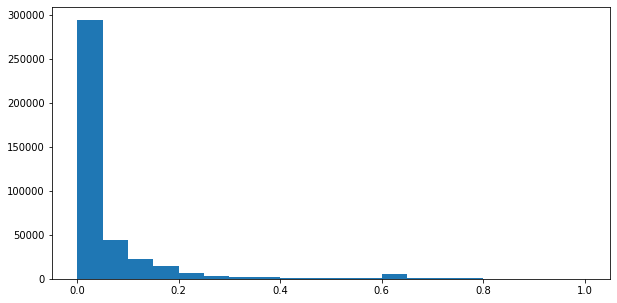

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

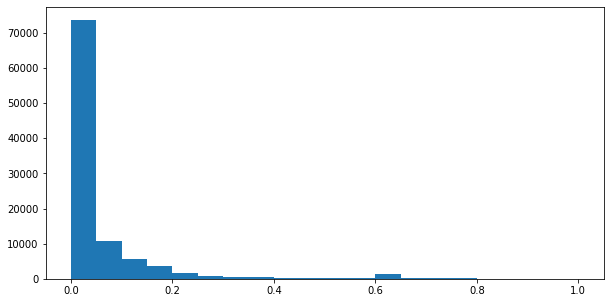

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'tanh'))
x.add(Dense(1024, activation = 'tanh'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model(shared_model, input_shape, b, m, is_sparse = True, print_summary = False)

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model(model, X_train, X_validation, Y_train, Y_validation, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 34s 35ms/step - loss: 0.0056 - ham_dist_loss: 0.0055 - prod_vec_loss: 0.0131 - prod_vec_1_loss: 0.0130 - sum_vec_loss: 1.3838e-04 - sum_vec_1_loss: 1.3074e-04 - ham_dist_rmse: 0.0741 - ham_dist_mae: 0.0275 - val_loss: 0.0015 - val_ham_dist_loss: 0.0015 - val_prod_vec_loss: 0.0034 - val_prod_vec_1_loss: 0.0036 - val_sum_vec_loss: 1.1295e-04 - val_sum_vec_1_loss: 1.2641e-04 - val_ham_dist_rmse: 0.0383 - val_ham_dist_mae: 0.0171
Epoch 2/20
781/781 [==============================] - 24s 31ms/step - loss: 0.0013 - ham_dist_loss: 0.0013 - prod_vec_loss: 0.0025 - prod_vec_1_loss: 0.0027 - sum_vec_loss: 9.4204e-05 - sum_vec_1_loss: 8.7685e-05 - ham_dist_rmse: 0.0361 - ham_dist_mae: 0.0159 - val_loss: 0.0012 - val_ham_dist_loss: 0.0012 - val_prod_vec_loss: 0.0019 - val_prod_vec_1_loss: 0.0021 - val_sum_vec_loss: 8.5234e-05 - val_sum_vec_1_loss: 7.4188e-05 - val_ham_dist_rmse: 0.0351 - val_ham_dist_mae: 0.0156
Epoch 3/20
781/781 [============

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{DeepLSH}$

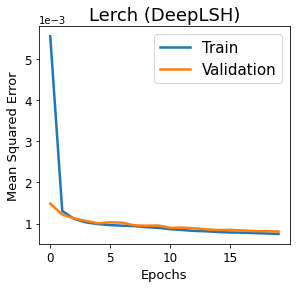

In [21]:
plt.rcParams["figure.figsize"] = (4.5,4)
plt.plot(siamese_model.history['loss'], linewidth = 2.5)
plt.plot(siamese_model.history['val_loss'], linewidth = 2.5)
plt.title('Lerch (DeepLSH)', fontsize = 18)
plt.ylabel('Mean Squared Error', fontsize = 13)
plt.xlabel('Epochs', fontsize = 13)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.savefig('Results/DeepLSH/loss-MSE.png', bbox_inches='tight')
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of LSH preserving loss

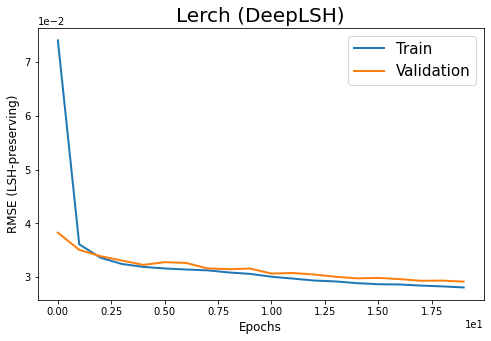

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Lerch (DeepLSH)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

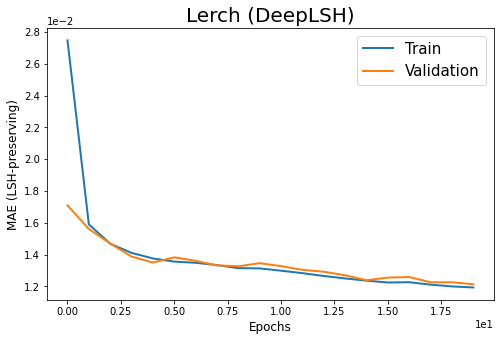

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Lerch (DeepLSH)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.   , 0.   , 0.575, 0.   , 0.106, 0.016, 0.08 , 0.156, 0.   ,
       0.211, 0.   , 0.219, 0.016, 0.354, 0.136, 0.   , 0.047, 0.015,
       0.047, 0.032, 0.109, 0.309, 0.   , 0.099, 0.078, 0.001, 0.05 ,
       0.017, 0.   , 0.031, 0.078, 0.125, 0.188, 0.   , 0.032, 0.   ,
       0.   , 0.   , 0.   , 0.053, 0.159, 0.   , 0.033, 0.184, 0.   ,
       0.   , 0.429, 0.14 , 0.016, 0.014], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.   , 0.573, 0.   , 0.069, 0.021, 0.115, 0.154, 0.   ,
       0.218, 0.   , 0.229, 0.   , 0.39 , 0.084, 0.   , 0.055, 0.01 ,
       0.023, 0.04 , 0.111, 0.228, 0.   , 0.093, 0.105, 0.   , 0.043,
       0.044, 0.   , 0.03 , 0.07 , 0.131, 0.157, 0.   , 0.038, 0.   ,
       0.   , 0.   , 0.   , 0.034, 0.171, 0.   , 0.042, 0.156, 0.   ,
       0.   , 0.474, 0.188, 0.03 , 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

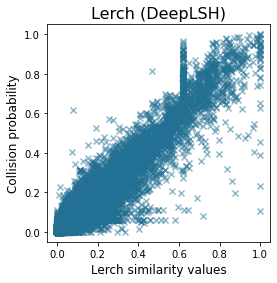

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Lerch (DeepLSH)', fontsize = 16)
plt.xlabel("Lerch similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/DeepLSH/Lerch-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.9093149299634131

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.8096022125980105

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-deep-lsh.model')

INFO:tensorflow:Assets written to: Models/model-deep-lsh.model/assets


In [33]:
#intermediate_model = keras.models.load_model('Models/model-deep-lsh.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [34]:
'First 64 bits'
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:64]

array([ 1.        , -1.        ,  0.9965098 , -1.        ,  1.        ,
       -1.        ,  1.        , -0.9999992 ,  1.        ,  1.        ,
        1.        , -1.        , -1.        , -1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        , -1.        ,
        1.        ,  1.        ,  1.        ,  1.        , -1.        ,
        1.        ,  1.        ,  1.        , -1.        ,  1.        ,
        1.        ,  1.        , -1.        ,  1.        ,  1.        ,
       -1.        ,  1.        ,  1.        , -1.        , -0.9999982 ,
       -1.        ,  1.        ,  1.        ,  1.        , -1.        ,
        1.        , -0.99999905, -1.        , -1.        , -1.        ,
        1.        , -1.        ,  0.99993867, -1.        ,  1.        ,
       -1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.99999833, -1.        , -1.        ,  1.        ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [35]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [36]:
hash_vectors

array([[ 1.        ,  1.        , -1.        , ...,  1.        ,
         1.        , -0.9904495 ],
       [ 1.        ,  1.        , -1.        , ...,  1.        ,
         1.        , -0.99787056],
       [ 1.        , -1.        ,  0.9942901 , ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [-1.        ,  1.        ,  0.9999767 , ..., -1.        ,
        -1.        ,  1.        ],
       [ 1.        , -1.        ,  1.        , ..., -1.        ,
         0.06759185,  1.        ],
       [-1.        ,  1.        ,  1.        , ..., -1.        ,
        -0.99208736, -1.        ]], dtype=float32)

In [37]:
np.mean(np.abs(hash_vectors))

0.9902594

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [38]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.8491435546875

### 3.3.4. Comparison between approximate hamming and real hamming

In [39]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

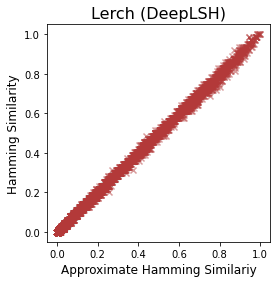

In [40]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Lerch (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Lerch-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [41]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [42]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)

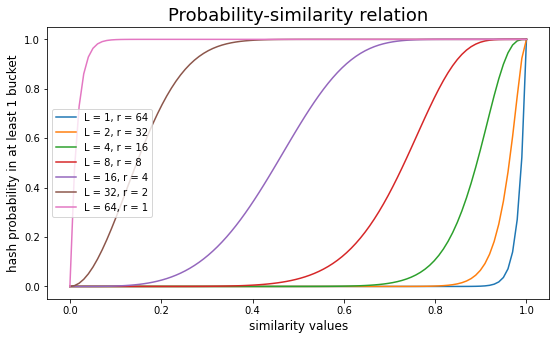

In [43]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [44]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Lerch', trace = False)

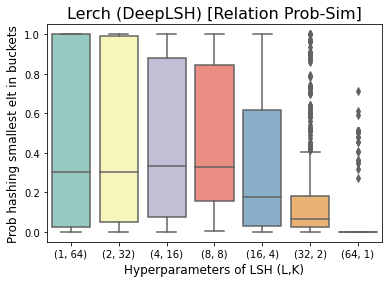

In [45]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Lerch (DeepLSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/DeepLSH/Lerch-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [46]:
'L = K = 8'
L, K = params[2]
L, K

(4, 16)

### 4.1.1. Mean and Median probability for all stack traces for a the best combination of $K$ and $L$

In [47]:
df_probLSH.mean()['(2, 32)']

0.46633084739695335

In [48]:
df_probLSH.median()['(2, 32)']

0.30293843105925866

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [49]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [50]:
with open('Hash-Tables/hash_tables_deeplsh.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [68]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

455

In [69]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{216, 455}

In [70]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [71]:
near_duplicates_sim = df_measures['Lerch'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

192802    0.732154
Name: Lerch, dtype: float64

In [72]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Lerch', n_stacks, n_duplicate_pairs)
set_real_nns

{797}

In [73]:
real_nns_sim[:n_duplicate_pairs]

351601    0.88485
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [74]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Lerch')

0.783

In [58]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Lerch')

0.9298737727910238

-----------------------------------------------------------------

In [75]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Lerch')

0.8199999999999994

In [60]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Lerch')

0.8935698447893574

-----------------------------------------------------------------

In [76]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Lerch')

0.850399999999999

In [62]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Lerch')

0.889198606271778

### 4.4.2. Generalized MRR

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))}$

In [77]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

0.5

In [78]:
df_knns = mean_generalized_mrr(n_stacks, params[:2], hash_vectors_hamming, b, df_measures ,'Lerch', trace = True)
df_knns.mean(skipna = True, axis = 0)

(1, 64)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(2, 32)
0
100
200
300
400
500
600
700
800
900
-----------------------------


(1, 64)    0.956061
(2, 32)    0.905412
dtype: float64

In [ ]:
df_knns.mean()['(8, 8)']

### 4.4.3. Recall w.r.t. LSH

In [79]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Lerch', trace = False)
df_recall.mean(skipna = True)

(1, 64)    0.069088
(2, 32)    0.240016
(4, 16)    0.521742
(8, 8)     0.717125
(16, 4)    0.756038
(32, 2)    0.716707
(64, 1)    0.964385
dtype: float64

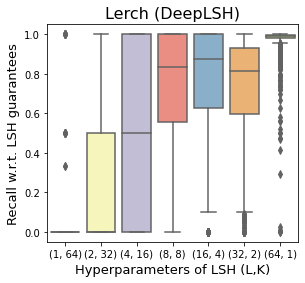

In [80]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('Lerch (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precison w.r.t. LSH

In [81]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Lerch', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.469697
(2, 32)    0.520165
(4, 16)    0.506043
(8, 8)     0.644216
(16, 4)    0.762140
(32, 2)    0.731864
(64, 1)    0.871133
dtype: float64

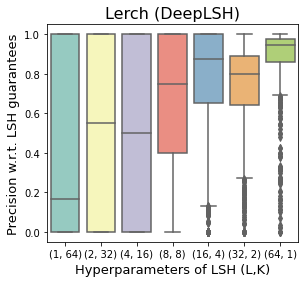

In [82]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('Lerch (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [83]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.067729
(2, 32)    0.205267
(4, 16)    0.377013
(8, 8)     0.573001
(16, 4)    0.702111
(32, 2)    0.683309
(64, 1)    0.904121
dtype: float64

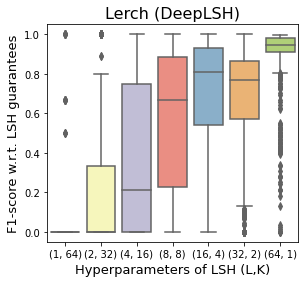

In [84]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('Lerch (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/fscore-LSH', bbox_inches='tight')
plt.show()